In [1]:
# %load_ext autoreload
# %autoreload 2
import pandas as pd
import numpy as np
import ast
from collections import Counter
# from pandarallel import pandarallel
import time
import math

In [2]:
# pandarallel.initialize(nb_workers=8, progress_bar=True, use_memory_fs=False)

In [3]:
# Data path
path = "./data/news_cleaned.csv"

In [4]:
cols = [
 # '',
 # 'id',
 'domain',
 'type',
 # 'url',
 'content',
 # 'scraped_at',
 # 'inserted_at',
 'updated_at',
 'title',
 'authors',
 # 'keywords',
 'meta_keywords',
 # 'meta_description',
 'tags',
 # 'summary',
 # 'source'
]

In [5]:
coltypes = {
 # '': np.int32,
 # 'id': np.int32,
 'domain': np.str,
 'type': np.str,
 # 'url': np.str,
 'content': np.str,
 # 'scraped_at': np.str,
 # 'inserted_at': np.str,
 # 'updated_at': np.str,
 'title': np.str,
 'authors': np.str,
 # 'keywords': np.str,
 'meta_keywords': np.str,
 # 'meta_description': np.str,
 'tags': np.str,
 # 'summary': np.str,
 # 'source': np.str
}

In [6]:
data = pd.read_csv(path, nrows=5_000_000, low_memory=True, memory_map=True, encoding="utf-8", quotechar='"', engine="c", usecols=cols, dtype=coltypes, error_bad_lines=False, warn_bad_lines=True)

/Users/pablokvitca/anaconda3/envs/nn-project/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
data.shape

(5000000, 8)

In [8]:
data["type"].value_counts()

political                     1421133
bias                           446692
conspiracy                     310923
fake                           246376
2018-02-07 23:39:33.852696     233205
unreliable                     227298
rumor                          185249
clickbait                      141034
unknown                        103485
junksci                         59010
satire                          55674
hate                            53221
2018-02-02 01:19:41.756664      34838
reliable                        15947
2017-11-10T11:18:44.524042      14065
Name: type, dtype: int64

In [9]:
data.describe()

,domain,type,content,updated_at,title,authors,meta_keywords,tags
count,3771345,3548150,3503302,3757280,3480082,2245762,3489237,1010156
unique,497,15,1931296,12,2231857,211015,410806,523847
top,ecowatch.com,political,Cowry Collective members participate in a time...,2018-02-07 23:39:33.852696,Is Palm Oil Explosion Driving Ebola Outbreak?,"Backgroundurl Avatar_Large, Nickname, Joined, ...",[''],View Tags
freq,746529,1421133,285230,2091105,32763,224948,2210754,163065


In [10]:
data.drop(data[data.type == "2018-02-07 23:39:33.852696"].index, inplace=True)
data.drop(data[data.type == "2018-02-02 01:19:41.756664"].index, inplace=True)
data.drop(data[data.type == "2017-11-10T11:18:44.524042"].index, inplace=True)

In [11]:
data.describe()

,domain,type,content,updated_at,title,authors,meta_keywords,tags
count,3489237,3266042,3489237,3489237,3466017,2231697,3489237,1010156
unique,494,12,1931295,2,2231856,211014,410806,523847
top,ecowatch.com,political,Cowry Collective members participate in a time...,2018-02-07 23:39:33.852696,Is Palm Oil Explosion Driving Ebola Outbreak?,"Backgroundurl Avatar_Large, Nickname, Joined, ...",[''],View Tags
freq,746529,1421133,285230,2091105,32763,224948,2210754,163065


In [12]:
data.shape

(4717892, 8)

In [13]:
data.type.describe()

count       3266042
unique           12
top       political
freq        1421133
Name: type, dtype: object

In [14]:
data.type.value_counts()

political     1421133
bias           446692
conspiracy     310923
fake           246376
unreliable     227298
rumor          185249
clickbait      141034
unknown        103485
junksci         59010
satire          55674
hate            53221
reliable        15947
Name: type, dtype: int64

In [15]:
def get_all_unique_from_list_col(df, col, f):
    l = set()
    for u in df[col].unique():
        if type(u) == str:
            l.update(f(u))
    return l

all_keywords = get_all_unique_from_list_col(data, "meta_keywords", ast.literal_eval)
all_tags = get_all_unique_from_list_col(data, "tags", lambda x: x.split(", "))
all_authors = get_all_unique_from_list_col(data, "authors", lambda x: x.split(", "))

In [16]:
print("Total keywords:", len(all_keywords))
print("Total tags:", len(all_tags))
print("Total authors:", len(all_authors))

Total keywords: 432375
Total tags: 469962
Total authors: 141914


In [21]:
counts_keywords = Counter()
for row in data["meta_keywords"]:
    if type(row) == str:
        counts_keywords.update(ast.literal_eval(row.lower()))

In [22]:
non_relevant_keywords = ["", "featured", "featured-home"]
for nrk in non_relevant_keywords:
    del counts_keywords[nrk]

In [23]:
counts_keywords.most_common(100)

[('climate change', 313727),
 ('business', 258123),
 ('energy', 220365),
 ('renewables', 192477),
 ('health', 105349),
 ('food', 100328),
 ('biodiversity', 98606),
 ('sustainable business', 97040),
 ('coal', 75628),
 ('fracking', 74660),
 ('politics', 73086),
 ('science', 66711),
 ('china', 42220),
 ('ebola', 33690),
 ('cuba', 33528),
 ('cop21', 32877),
 ('pipelines', 32852),
 ('russia', 32836),
 ('tips', 32300),
 ('transportation', 31966),
 ('donald trump', 26632),
 ('united states', 23972),
 ('barack obama', 20173),
 ('hillary clinton', 17902),
 ('economics', 17598),
 ('news', 15564),
 ('big government', 14772),
 ('finance', 14703),
 ('markets', 14647),
 ('analysis', 14429),
 ('zerohedge', 14215),
 ('zero hedge', 14210),
 ('wikileaks', 12538),
 ('syria', 12478),
 ('world', 12245),
 ('vdare.com', 11642),
 ('national security', 10905),
 ('the onion', 10163),
 ('media', 9834),
 ('ohio', 9492),
 ('white house', 9176),
 ('bernie sanders', 8878),
 ('natural medicine', 8797),
 ('functional 

In [24]:
counts_tags = Counter()
for row in data["tags"]:
    if type(row) == str:
        counts_tags.update([s.strip() for s in row.lower().split(", ")])

In [25]:
non_relevant_tags = [
    "view tags", 
    "next", 
    "4062 followers duggar family", 
    "3756 followers sylvester stallone", 
    "view non-amp version", 
    "1",
    "4217 followers dragon ball super",
    "2",
    ]
for nrt in non_relevant_tags:
    del counts_tags[nrt]

In [26]:
counts_tags.most_common(100)

[('russia', 65416),
 ('donald trump', 60004),
 ('hillary clinton', 42836),
 ('syria', 35145),
 ('9/11 articles', 31523),
 ('race/crime articles', 31523),
 ('american pravda articles', 31523),
 ('race/iq articles', 31523),
 ('israel', 31399),
 ('libya', 30813),
 ('united states', 30101),
 ('immigration', 29121),
 ('politics', 28905),
 ('barack obama', 25986),
 ('trump', 25812),
 ('obama', 24607),
 ('isis', 24055),
 ('europe', 23574),
 ('iran', 23016),
 ('china', 22821),
 ('cia', 22379),
 ('benghazi', 22064),
 ('children', 21172),
 ('terrorism', 20555),
 ('islam', 20424),
 ('north korea', 19914),
 ('irs', 19148),
 ('epa', 18967),
 ('iraq', 18534),
 ('school', 17817),
 ('transportation', 17659),
 ('financial disclosure', 17637),
 ('hillary clinton email scandal', 17531),
 ('trump administration', 17399),
 ('religion', 17373),
 ('irs docs', 17369),
 ('ukraine', 17339),
 ('turkey', 17327),
 ('retirement', 17115),
 ('foia', 17001),
 ('vanguard', 16725),
 ('middle east', 16680),
 ('india', 16

In [27]:
counts_authors = Counter()
for row in data["authors"]:
    if type(row) == str:
        counts_authors.update([s.strip() for s in row.lower().split(", ")])

In [28]:
counts_authors.most_common(100)

[('lorraine chow', 746451),
 ('common dreams', 638516),
 ('guest contributor', 507058),
 ('the conversation', 384011),
 ('david leestma', 362631),
 ('yes', 285256),
 ('environmental working group', 254739),
 ('ronnie cummins', 254659),
 ('the climate reality project', 254658),
 ('sierra club', 254636),
 ('rainforest action network', 254636),
 ('backgroundurl avatar_large', 224956),
 ('nickname', 224956),
 ('joined', 224956),
 ('created_at', 224956),
 ('story count', 224956),
 ('n_stories', 224956),
 ('comment count', 224956),
 ('n_comments', 224956),
 ('popular tags', 224956),
 ('showtags popular_tags', 224948),
 ('organic consumers association', 156531),
 ("our children's trust", 107978),
 ('american wild horse campaign', 107975),
 ('anastasia pantsios', 101821),
 ('stefanie spear', 98031),
 ('climate nexus', 82670),
 ('daily kos', 76786),
 ('happy cog studios - http', 76783),
 ('www.happycog.com', 76783),
 ('david codrea', 70085),
 ('tom mchale', 70085),
 ('jeff knox', 70085),
 ('the

In [29]:
non_relevant_authors = [
    "yes", 
    "nickname", 
    "joined", 
    "created_at", 
    "story count", 
    "n_stories", 
    "comment count", 
    "n_comments", 
    "popular tags", 
    "showtags popular_tags", 
    "the",
    "view all posts",
    "http",
    "https",
    "",
    "background",
    "ffffff",
    "solid",
    "border-style",
    "color",
    "border-color"
    "border-top-width",
    "border-right-width",
    "about me"
]
for nra in non_relevant_authors:
    del counts_authors[nra]

In [30]:
fake_types = [
#     "political",
    "bias",
    "conspiracy",
    "fake",
    "unreliable",
    "rumor",
    "clickbait",
#     "unknown",
    "junksci",
    "satire",
    "hate",
#    "reliable"
]

In [31]:
data["fake"] = data.type.apply(lambda x: 1 if x in fake_types else 0)

In [32]:
data["fake"].value_counts()

0    2992415
1    1725477
Name: fake, dtype: int64

In [33]:
data.dropna(subset=['type', 'content', 'title', 'fake'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [40]:
data.shape

(3242862, 9)

In [41]:
def add_metadata_as_has_col(df, col, all_metadata, prefix, cache):
    start_time = int(time.time() * 1000)
    n = len(all_metadata)
        
    print("Starting...")
    for i, metadata in enumerate(all_metadata):
        df[prefix + metadata[0]] = df.apply(lambda row: 1 if (row.name < len(cache) and metadata[0] in cache[row.name]) else 0, axis=1)
        print("Processed {} of {} metadata keys ({} ms)".format(i + 1, n, int(time.time() * 1000) - start_time))
    print("Done!")

In [42]:
mt = set()
cache_keywords = [set([a for a in ast.literal_eval(d.lower()) if a not in non_relevant_keywords]) if type(d) == str else mt for d in data["meta_keywords"]]
cache_tags = [set([s.strip() for s in d.lower().split(", ") if s.strip() not in non_relevant_tags]) if type(d) == str else mt for d in data["tags"]]
cache_authors = [set([s.strip() for s in d.lower().split(", ") if s.strip() not in non_relevant_authors]) if type(d) == str else mt for d in data["authors"]]

In [43]:
add_metadata_as_has_col(data, "meta_keywords", counts_keywords.most_common(100), "has_mk_", cache_keywords)

Starting...
Processed 1 of 100 metadata keys (60662 ms)
Processed 2 of 100 metadata keys (98319 ms)
Processed 3 of 100 metadata keys (130334 ms)
Processed 4 of 100 metadata keys (168962 ms)
Processed 5 of 100 metadata keys (204308 ms)
Processed 6 of 100 metadata keys (245835 ms)
Processed 7 of 100 metadata keys (282222 ms)
Processed 8 of 100 metadata keys (319330 ms)
Processed 9 of 100 metadata keys (364577 ms)
Processed 10 of 100 metadata keys (395164 ms)
Processed 11 of 100 metadata keys (439795 ms)
Processed 12 of 100 metadata keys (484615 ms)
Processed 13 of 100 metadata keys (523519 ms)
Processed 14 of 100 metadata keys (562242 ms)
Processed 15 of 100 metadata keys (617430 ms)
Processed 16 of 100 metadata keys (673128 ms)
Processed 17 of 100 metadata keys (718015 ms)
Processed 18 of 100 metadata keys (769898 ms)
Processed 19 of 100 metadata keys (815237 ms)
Processed 20 of 100 metadata keys (853849 ms)
Processed 21 of 100 metadata keys (899966 ms)
Processed 22 of 100 metadata keys

In [44]:
add_metadata_as_has_col(data, "tags", counts_tags.most_common(100), "has_tag_", cache_tags)

Starting...
Processed 1 of 100 metadata keys (101443 ms)
Processed 2 of 100 metadata keys (191164 ms)
Processed 3 of 100 metadata keys (336666 ms)
Processed 4 of 100 metadata keys (421266 ms)
Processed 5 of 100 metadata keys (560434 ms)
Processed 6 of 100 metadata keys (711760 ms)
Processed 7 of 100 metadata keys (833028 ms)
Processed 8 of 100 metadata keys (953682 ms)
Processed 9 of 100 metadata keys (1080973 ms)
Processed 10 of 100 metadata keys (1197739 ms)
Processed 11 of 100 metadata keys (1291291 ms)
Processed 12 of 100 metadata keys (1414676 ms)
Processed 13 of 100 metadata keys (1518786 ms)
Processed 14 of 100 metadata keys (1610979 ms)
Processed 15 of 100 metadata keys (1732177 ms)
Processed 16 of 100 metadata keys (1814636 ms)
Processed 17 of 100 metadata keys (1899238 ms)
Processed 18 of 100 metadata keys (1981076 ms)
Processed 19 of 100 metadata keys (2057331 ms)
Processed 20 of 100 metadata keys (2154641 ms)
Processed 21 of 100 metadata keys (2234994 ms)
Processed 22 of 10

In [45]:
add_metadata_as_has_col(data, "authors", counts_authors.most_common(100), "has_author_", cache_authors)

Starting...
Processed 1 of 100 metadata keys (114531 ms)
Processed 2 of 100 metadata keys (231129 ms)
Processed 3 of 100 metadata keys (357274 ms)
Processed 4 of 100 metadata keys (469925 ms)
Processed 5 of 100 metadata keys (582327 ms)
Processed 6 of 100 metadata keys (692761 ms)
Processed 7 of 100 metadata keys (806833 ms)
Processed 8 of 100 metadata keys (938606 ms)
Processed 9 of 100 metadata keys (1069980 ms)
Processed 10 of 100 metadata keys (1207385 ms)
Processed 11 of 100 metadata keys (1350701 ms)
Processed 12 of 100 metadata keys (1467574 ms)
Processed 13 of 100 metadata keys (1578365 ms)
Processed 14 of 100 metadata keys (1694965 ms)
Processed 15 of 100 metadata keys (1810502 ms)
Processed 16 of 100 metadata keys (1931867 ms)
Processed 17 of 100 metadata keys (2064039 ms)
Processed 18 of 100 metadata keys (2197175 ms)
Processed 19 of 100 metadata keys (2334003 ms)
Processed 20 of 100 metadata keys (2469100 ms)
Processed 21 of 100 metadata keys (2616668 ms)
Processed 22 of 10

In [46]:
data.drop("meta_keywords", axis=1, inplace=True)
data.drop("tags", axis=1, inplace=True)
data.drop("authors", axis=1, inplace=True)

In [47]:
simple_cols = ["title", "content", "type", "fake", "domain", "updated_at"]

In [73]:
data.to_csv("./data/news_wkta_all.csv", index=False)

In [48]:
def recover_meta_counts(df, prefix):
    counts = Counter()
    for col in df.columns:
        if prefix in col:
            data_slice = df[df[col] == 1]
            counts[col[len(prefix):]] += data_slice[col].sum()
    return counts

In [49]:
def filter_data_by_meta(df, prefix, meta_counts, n):
    req_cols = [prefix + meta for meta, _ in meta_counts.most_common(n)]
    
    all_criteria = [df[col] == 1 for col in req_cols]
    criteria = df[req_cols[0]] == 1
    for col in req_cols[1:]:
        criteria = criteria | df[col] == 1
        
    return df.loc[criteria]

In [50]:
data["sample_weights"] = data.groupby('fake')['fake'].transform('count')

In [51]:
filtered_data = filter_data_by_meta(data, "has_mk_", counts_keywords, 25)

In [52]:
data.fake.value_counts(normalize=True)

1    0.524979
0    0.475021
Name: fake, dtype: float64

<AxesSubplot:>

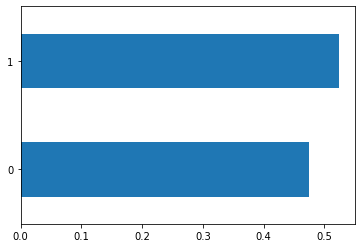

In [53]:
data.fake.value_counts(normalize=True).sort_values().plot(kind = 'barh')

In [54]:
filtered_data.fake.value_counts(normalize=True)

0    0.902694
1    0.097306
Name: fake, dtype: float64

<AxesSubplot:>

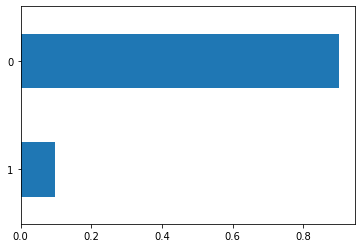

In [55]:
filtered_data.fake.value_counts(normalize=True).sort_values().plot(kind = 'barh')

In [56]:
tiny_balanced_sample = filtered_data.sample(n=25_000, weights = filtered_data["sample_weights"], random_state=9034)

In [ ]:
tiny_balanced_sample = pd.read_csv(path, memory_map=True, encoding="utf-8", quotechar='"', engine="c", usecols=cols, dtype=coltypes, error_bad_lines=False, warn_bad_lines=True, compression="zip")

In [57]:
tiny_balanced_sample.fake.value_counts(normalize=True)

domain           type        content                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [58]:
tiny_balanced_sample.to_csv("./data/news_bal_25k.csv", index=False)

In [59]:
tiny_data = filtered_data.sample(n=25_000, random_state=9034)

In [60]:
tiny_data.to_csv("./data/news_simple_25k.csv", columns=simple_cols, index=False)

In [61]:
tiny_data.to_csv("./data/news_wkta_25k.csv", index=False)

In [62]:
smaller_balanced_sample = filtered_data.sample(n=50_000, weights = filtered_data["sample_weights"], random_state=9034)

In [63]:
smaller_balanced_sample.to_csv("./data/news_bal_50k.csv", index=False)

In [64]:
smaller_data = filtered_data.sample(n=50_000, random_state=9034)

In [65]:
smaller_data.to_csv("./data/news_simple_50k.csv", columns=simple_cols, index=False)

In [66]:
smaller_data.to_csv("./data/news_wkta_50k.csv", index=False)

In [67]:
small_balanced_sample = filtered_data.sample(n=100_000, weights = filtered_data["sample_weights"], random_state=9034)

In [68]:
small_balanced_sample.to_csv("./data/news_bal_100k.csv", index=False)

In [69]:
small_data = filtered_data.sample(n=100_000, random_state=9034)

In [70]:
small_data.to_csv("./data/news_simple_100k.csv", columns=simple_cols, index=False)

In [71]:
small_data.to_csv("./data/news_wkta_100k.csv", index=False)

In [72]:
import sys
original_stdout = sys.stdout # Save a reference to the original standard output
with open('./data/metadata_counts.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print(counts_keywords, counts_tags, counts_authors)
    sys.stdout = original_stdout # Reset the standard output to its original value